# Summary

This notebook studies SIS model in three aspects:

* In Part One, I study the __Deterministic SIS Model__ with theoretical analysis and numerical analysis;

* In Part Two, I study the __Stochastic SIS Model__ with numerical analysis;

* In Part Three, I study the __Stochastic SIS Model__ on Barabási–Albert network and Erdős–Rényi–Gilbert network.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from scipy.sparse import csr_matrix
from random import random

# SIS Model

The $S-I$ and $S-I-R$ models both capture the dynamics of acute infections that either kill or confer lifelong immunity once recovered. However, numerous infectious diseases, including COVID-19, confer no long-lasting immunity. For these diseases, individuals can be infected multiple times throughout their lives, with no apparent immunity.

In SIS model, recovery from infection is followed by an instant return to the susceptible pool


<div>
<img src="./img/SIS_model.png" width="600"/>
</div>


# Part One: Deterministic SIS Model


The equations governing the $S-I-S$ model are:
$$
\begin{align*}
\frac{ds(t)}{dt} \; =& \; \mu i(t) -\beta  i(t)s(t) \\
\frac{di(t)}{dt} \; =& \;   \beta i(t)s(t) - \mu i(t) \\
\end{align*}
$$


* In this model, we still get that the basic reproduction number is equal to:

$$ R_0 = \frac{\beta}{\mu} $$

* Also, by using the relationship $s(t)+i(t) = 1$, we can look at the evolution of the fraction of infectives in the population:

$$\frac{di}{dt} \; = \;   \beta is - \mu i = (\beta - \beta i - \mu) i $$


$$(\beta - \beta i - \mu) i = \left(1 -  i - \frac{\mu}{\beta}\right) \beta i $$


$$\left(1 -  i - \frac{\mu}{\beta}\right) \beta i = \left(1 -  i - \frac{1}{R_0}\right) \beta i $$


$$\frac{di}{dt} = \left(1 -  i - \frac{1}{R_0}\right) \beta i $$


* The equilibrium number of infectives in this population is obtained by setting the previous equation to zero and solving for $i^∗$ . 



$$i^∗ = \left(1 − \frac{1}{R_0} \right) $$

* Notice that, the analytical solution for $i(t)$ is:

$$i(t) = \frac{\beta - \mu}{\beta + c e^{-\mu(R_0 -1)t}}$$

* If $R_0<1$, $$i(\infty) = 0$$

* If $R_0>1$, $$i(\infty) = 1 - \frac{1}{R_0}$$


* Therefore the ___endemic state___ $i^∗$ is a stable solution as long as $R_0>1$ 

$$i^∗ = \left(1 − \frac{1}{R_0} \right) $$

* The intution for this is that to reach the endemic state the infection must have the capacity to sustain the chain of transmission at least in the case of a fully susceptible population


* Therefore, although the SIS model is in appearance just a small variation of the $S-I-R$ and $S-I$ models, it defines a new type of dynamical behavior leading to an ___endemic state___ with a stationary value for the prevalence of infected individuals

* In general all models that allow the loss of permanent immunity after the host’s recovery may exhibit long term persistence of the infection as exemplified by the $S-I-S$ model

In [2]:
def sis_deterministic(N,I0,beta,mu,T):
    S = np.zeros(T+1)
    I = np.zeros(T+1)

    S[0] = N-I0
    I[0] = I0
    
    
    for t in range(1,T+1):
        S[t] = S[t-1] - beta*S[t-1]*I[t-1]/N + mu*I[t-1]
        I[t] = I[t-1] + beta*S[t-1]*I[t-1]/N - mu*I[t-1]
    
    return S,I
    

Text(0, 0.5, 'Number of individuals')

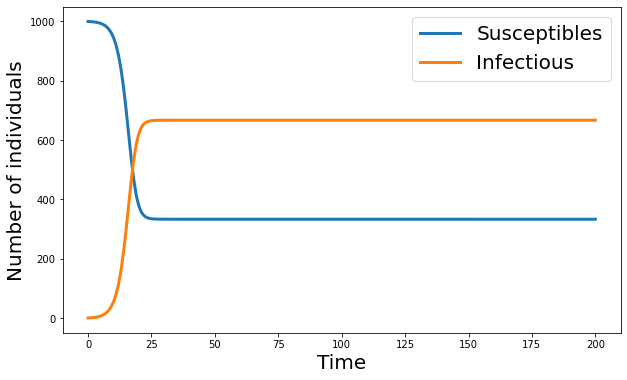

In [3]:
N = 1000
I0 = 1
beta = 0.75
mu = 0.25
T = 200
S,I = sis_deterministic(N,I0,beta,mu,T)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(S, label='Susceptibles',lw=3)
ax.plot(I, label='Infectious', lw=3)
ax.legend(fontsize=20)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Number of individuals', fontsize=20)

### The effect of  $\beta$  change

Text(0, 0.5, 'Number of individuals')

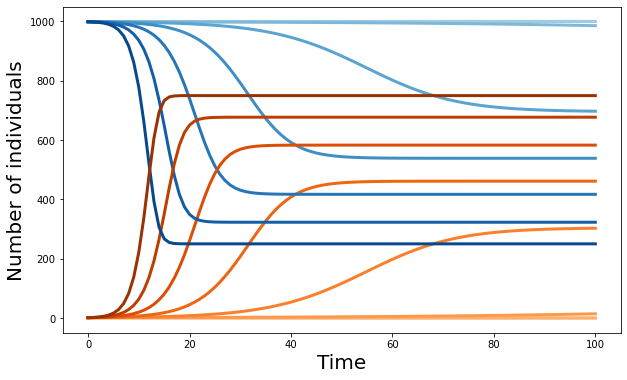

In [4]:
N = 1000
I0 = 1
T = 100

betas = np.logspace(np.log(1e-1),0,10, base=np.e)#np.logspace(0,1,10, base=np.e)
n_colors = len(betas)

I_colors = sns.color_palette('Oranges',n_colors=n_colors)
S_colors = sns.color_palette('Blues',n_colors=n_colors)

fig, ax = plt.subplots(figsize=(10,6))

for k, beta in enumerate(betas):
    S,I = sis_deterministic(N,I0,beta,mu,T)
    ax.plot(S, label='Susceptibles',lw=3, color=S_colors[k])
    ax.plot(I, label='Infectious', lw=3, color=I_colors[k])
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Number of individuals', fontsize=20)

Text(0, 0.5, 'Time to S=0')

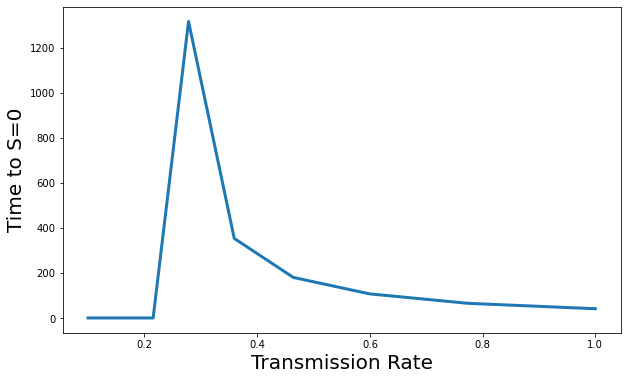

In [5]:
N = 1000
I0 = 1
T = int(1e5)

betas = np.logspace(np.log(1e-1),0,10, base=np.e)
n_colors = len(betas)

I_colors = sns.color_palette('Oranges',n_colors=n_colors)
S_colors = sns.color_palette('Blues',n_colors=n_colors)

fig, ax = plt.subplots(figsize=(10,6))

S_eq = []
for k, beta in enumerate(betas):
    S,I = sis_deterministic(N,I0,beta,mu,T)
    S_eq.append(np.argmin(S))

ax.plot(betas, S_eq, lw=3)
ax.set_xlabel('Transmission Rate', fontsize=20)
ax.set_ylabel('Time to S=0', fontsize=20)

# Part Two: Stochastic SIS Model

In [6]:
def sis_stochastic(N, I0, beta,mu, T, num_replications):
    S = np.zeros((T+1,num_replications))
    I = np.zeros((T+1,num_replications))
    S[0,:] = N-I0
    I[0,:] = I0

    for b in range(0,num_replications):
        for t in range(1,T + 1):
            p = beta*I[t-1,b] / N
            new_infected = np.random.binomial(S[t-1,b], p)
            new_recovered = np.random.binomial(I[t-1,b],mu)
            S[t,b] = S[t-1,b] - new_infected + new_recovered
            I[t,b] = I[t-1,b] + new_infected - new_recovered
            
    return S,I

In [7]:
N = 1000
I0 = 1
beta = 0.5
mu = 0.25
T = 200
B = 200

S,I = sis_stochastic(N,I0,beta,mu,T,B)

Text(0, 0.5, 'Number of individuals')

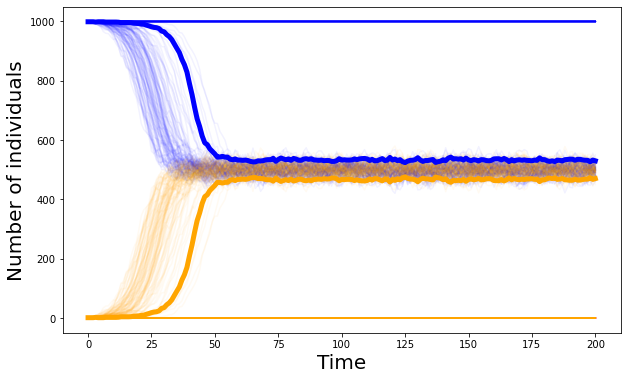

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
__ = ax.plot(S, color='blue', alpha=0.05)
__ = ax.plot(I, color='orange', alpha=0.05)
ax.plot(np.median(S,axis=1), lw=5, color='blue')
ax.plot(np.median(I,axis=1), lw=5, color='orange')

ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Number of individuals', fontsize=20)

# Part Three: Stochastic SIS Model on Barabási–Albert network and Erdős–Rényi–Gilbert network

In [9]:
def generate_ba(N, m, m0=2):    
    if m>m0:
        raise NameError('Error! m cannot be larger than m0!')
    
    degrees = np.zeros((N,))
    nodes = np.arange(N)
    edges = []
    
    init_nodes = list(range(m0))
    edges += list(combinations(init_nodes,2))
    degrees[init_nodes] = m0-1.0
        
    Nt = m0
    
    while Nt<N:
        target_nodes = np.random.choice(nodes[:Nt],size=m,replace=False,p=degrees[:Nt]/degrees[:Nt].sum())
        edges += list(zip([Nt]*m,target_nodes))
        degrees[target_nodes] += 1
        degrees[Nt] += m
        Nt+=1

    nodes_i,nodes_j = zip(*edges)
    ones = np.ones(len(nodes_i)*2,dtype=int)
    
    A = csr_matrix((ones,(nodes_i+nodes_j,nodes_j+nodes_i)), shape=(N,N))
    
    return A


def generate_gilbert(N, p, implementation=1):
    if implementation == 0:
        A = np.zeros((N,N))
        for row in xrange(N):
            for col in xrange(row+1,N):
                if random()<p:
                    A[row,col] = 1
                    A[col,row] = 1
    elif implementation == 1: 
        A = np.zeros((N,N))
        L = N*(N-1)//2
        rands = np.random.rand(L)
        rows, cols = np.triu_indices(n=N,m=N,k=1)
        A[rows,cols] = rands<p
        A[cols,rows] = rands<p
    elif implementation == 2:
        A = np.zeros((N,N))
        L_list = combinations(range(N),2)
        edges = [edge for edge in L_list if random()<p]
        if edges:
            rows,cols = zip(*edges)
            A[rows,cols] = 1 
            A[cols,rows] = 1 
    return csr_matrix(A)


def sis_network(A,I0,beta,mu,T):
    N = A.shape[0]
    S = np.zeros(T+1)
    I = np.zeros(T+1)

    S[0] = N-I0
    I[0] = I0    
      
    node_status = {node:{'current_status':'S', 'next_status':None} for node in range(N)}
    
    init_infected = np.random.permutation(N)[:I0]
    for node in init_infected:
        node_status[node]['current_status'] = 'I'
        
    for t in range(1,T+1):
        S[t] = S[t-1]
        I[t] = I[t-1]
        for node in range(N):
            if node_status[node]['current_status']=='S':
                for neigh in A[node].indices:
                    if node_status[neigh]['current_status']=='I':
                        if np.random.rand()<beta:
                            node_status[node]['next_status']='I'
                            S[t] -= 1
                            I[t] += 1
                            break
            elif node_status[node]['current_status']=='I':
                if np.random.rand()<mu:
                    node_status[node]['next_status']='S'
                    S[t] += 1
                    I[t] -= 1

        for node in range(N):
            if node_status[node]['next_status']:
                node_status[node]['current_status'] = node_status[node]['next_status']
                node_status[node]['next_status'] = None
            
    return S,I
    

### Stochastic SIS Model on Barabási–Albert network

Text(0, 0.5, 'Number of individuals')

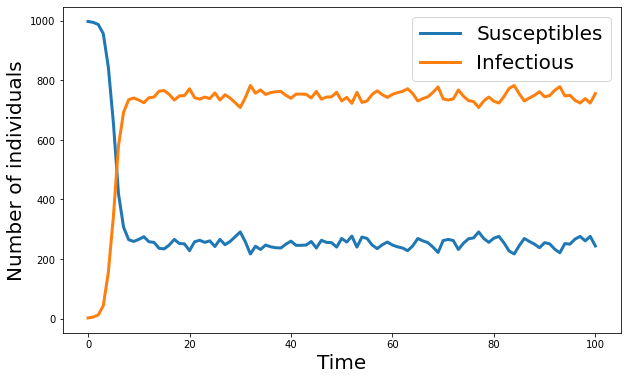

In [10]:
N = 1000
A_ba = generate_ba(N,2)
I0 = 2
T = 100
beta = 0.5

S_ba,I_ba = sis_network(A_ba,I0,beta,mu,T)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(S_ba, label='Susceptibles',lw=3)
ax.plot(I_ba, label='Infectious', lw=3)
ax.legend(fontsize=20)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Number of individuals', fontsize=20)

### Stochastic SIS Model on Erdős–Rényi–Gilbert network

Text(0, 0.5, 'Number of individuals')

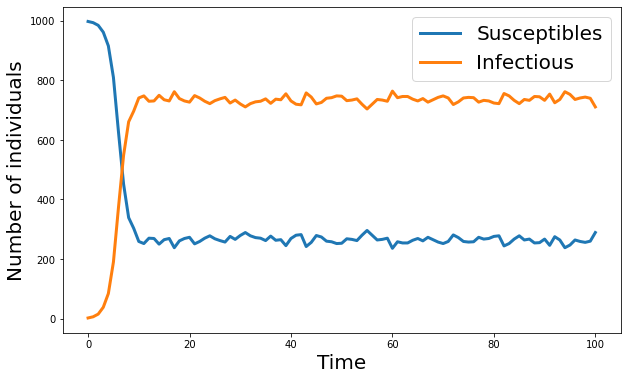

In [11]:
avg_k_ba = np.asarray(A_ba.sum(axis=0)).reshape(-1).mean()
p = avg_k_ba/(N-1)
A_er = generate_gilbert(N,p)

S_er,I_er = sis_network(A_er,I0,beta,mu,T)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(S_er, label='Susceptibles',lw=3)
ax.plot(I_er, label='Infectious', lw=3)
ax.legend(fontsize=20)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Number of individuals', fontsize=20)

Text(0, 0.5, 'Number of individuals')

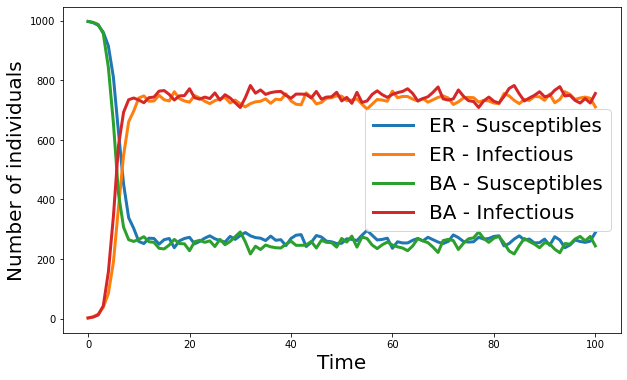

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(S_er, label='ER - Susceptibles',lw=3)
ax.plot(I_er, label='ER - Infectious', lw=3)
ax.plot(S_ba, label='BA - Susceptibles',lw=3)
ax.plot(I_ba, label='BA - Infectious', lw=3)
ax.legend(fontsize=20)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Number of individuals', fontsize=20)